## Задание 2

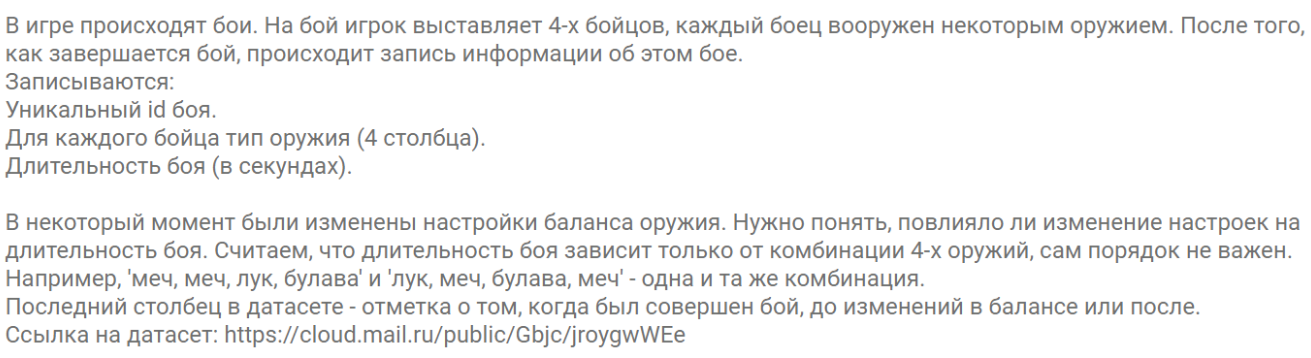

## Решение

### Импорт библиотек

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import f_oneway, mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

from catboost import CatBoostClassifier

from pandas_profiling import ProfileReport

### Загрузка данных

Скачаем данные по указанной в задании ссылке и прочитаем файл `data_test.csv` в `DataFrame`. 

In [ ]:
df = pd.read_csv('data_test.csv', encoding = "cp1251")

In [ ]:
df

,battle_id,unit_1,unit_2,unit_3,unit_4,len,balance_mark
0,103921,топор,лук,булава,лук,17.35,before
1,117214,посох,посох,лук,лук,21.84,before
2,115502,меч,посох,булава,топор,16.00,before
3,110102,булава,лук,лук,булава,17.22,before
4,104989,меч,посох,булава,посох,19.20,before
...,...,...,...,...,...,...,...
19995,108834,посох,булава,лук,посох,26.37,after
19996,119941,посох,меч,лук,посох,23.73,after
19997,112911,топор,посох,булава,топор,27.73,after
19998,111684,меч,топор,посох,меч,24.20,after


### Первичный анализ: посмотрим на зависимости

In [ ]:
ProfileReport(df, title="Pandas Profiling Report")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Статистика по длительности боя

In [ ]:
print('Статистика по длительности боя до изменения баланса')
print(df[df['balance_mark'] == 'before']['len'].describe())
print()
print('Статистика по длительности боя после изменения баланса')
print(df[df['balance_mark'] == 'after']['len'].describe())

Статистика по длительности боя до изменения баланса
count    10000.000000
mean        19.973604
std          2.875324
min         15.000000
25%         17.510000
50%         19.960000
75%         22.460000
max         25.000000
Name: len, dtype: float64

Статистика по длительности боя после изменения баланса
count    10000.000000
mean        24.123115
std          3.799379
min          5.010000
25%         21.710000
50%         24.300000
75%         27.090000
max         30.000000
Name: len, dtype: float64


Можно сразу отметить, что набор данных является сбалансированным, так как строки с метками `before` и `after` находятся в равном соотношении.

### Реализация некоторых функций и классов для проведения анализа

Создадим класс `ABTesting`.

Методы класса:
- `CreateCombinations` собирает комбинации оружия для каждой строчки в `DataFrame` и объединяет их в единых список. При этом инициализируется поле `C`, в котором хранятся списки с комбинациями оружия для каждой строчки. Все списки также сортируются, поскольку нам важен лишь состав оружия, а не его порядок в строке.

- `EncoderToLabels` перекодирует длинный список из комбинаций оружия в строку из четырех букв, каждая буква отвечает за свой тип оружия: *б* -- булава, *л* -- лук, *м* -- меч, *п* -- посох и *т* -- топор. (Из результатов `ProfileReport` знаем, что всего 5 типов оружия). В методе инициализируется поле `vectors` в котором хранятся комбинации оружия уже в виде строк.

- `OneHotEncoder` осуществляет перекодировку комбинаций оружия в бинарные векторы (`one-hot-encoding`). Данные векторы далее будут использованы для проведения анализа на основе построения моделей машинного обучения. В методе инициализирцется поле `binary` с бинарными векторами. 

- `StatTestResults` осуществляет вывод графиков для проводимых статистических тестов и комбинаций оружия (закодированных в виде строк) для которых нет оснований отклонить нулевую гипотезу статистического теста. В качестве изменяемых параметров имеет: 
  - название проводимого статистического теста `testname`
  - уровень значимости `alpha`
  
- `BoxPlotsResults` выводит ящики с усами для комбинаций оружия (закодированных строками).

- `PCA` осуществляет предобработку датасета с помощью `frequency encoding` и вывод проекций данных на главные компоненты.

- `MLDataSet` осуществляет создание модификацию исходного `DataFrame` путем изменения столбцов `unit_1` - `unit_4` на перекодированные с помощью `one-hot-encoding`.

In [ ]:
class ABTesting():
    def __init__(self, X):
        self.X = X

        
    def CreateCombinations(self):
        self.C = []
        for index, row in self.X.iterrows():
            a = [row['unit_1'], row['unit_2'], row['unit_3'], row['unit_4']]
            a.sort()
            self.C.append(a)
        
        
    def EncoderToLabels(self):
        switch = {
            'булава' : 'б',
            'лук' : 'л',
            'меч' : 'м',
            'посох' : 'п',
            'топор' : 'т'
        }
        self.vectors = []
        self.CreateCombinations()
        for c in self.C:
            vector = switch[c[0]] + switch[c[1]] + switch[c[2]] + switch[c[3]]
            self.vectors.append(vector)
            
        self.combinations = list(set(self.vectors))
        self.combinations.sort()
        self.X['comb'] = self.vectors
        
        
    def OneHotEncoder(self):
        switch = {
            'булава' : [0, 0, 0, 0, 1],
            'лук' : [0, 0, 0, 1, 0],
            'меч' : [0, 0, 1, 0, 0],
            'посох' : [0, 1, 0, 0, 0],
            'топор' : [1, 0, 0, 0, 0]
        }
        self.binary = []
        self.CreateCombinations()
        for c in self.C:
            decimal = 0
            vector = switch[c[0]] + switch[c[1]] + switch[c[2]] + switch[c[3]]
            self.binary.append(vector)
        
        self.binary = np.array(self.binary).T
    
    
    def StatTestResults(self, testname, alpha = 0.05):
        names = {'f_oneway' : ['p-value теста ANOVA', 
                               'Проверка гипотезы о равенстве средних двух выборок: до изменения баланса и после', 
                               f_oneway],
                 'mannwhitneyu' : ['p-value теста Манна-Уитни', 
                                   'Проверка гипотезы о равенстве распределений выборок: до изменения баланса и после',
                                    mannwhitneyu]
                }
        
        fig = plt.figure(figsize = (18, 6))
        
        self.EncoderToLabels()

        plt.xlabel('комбинация оружия', fontsize=15)
        plt.ylabel(names[testname][0], fontsize=15)
        plt.rcParams.update({'font.size': 10})
        plt.xticks(rotation=90)
        
        eps = 0.05
        i, j, k = 0, 0, 0
        less, more, same = 0, 0, 0
        not_reject = []
        self.PV = []
        for c in self.combinations:
            
            X_mod = self.X[self.X['comb'] == c]
            X_before = X_mod[X_mod['balance_mark'] == 'before']['len']
            X_after = X_mod[X_mod['balance_mark'] == 'after']['len']

            if abs(X_before.mean() - X_after.mean()) < eps:
                same += 1
            elif X_before.mean() > X_after.mean():
                less += 1 
            else:
                more += 1

            # слишком маленькая выборка для проведения статистического теста
            if (len(X_before) < 50 and testname != 'mannwhitneyu'): 
                k += 1
                continue
            else:
                pv = names[testname][2](X_before.to_numpy(), X_after.to_numpy()).pvalue
                self.PV.append(pv)
                if pv < alpha and i == 0:
                    plt.scatter(c, pv, color = 'red', 
                                label = f'есть основания отклонить гипотезу с уровнем значимости {alpha}', s = 100)
                    i = 1
                elif pv < alpha and i == 1:
                    plt.scatter(c, pv, color = 'red', s = 100)
                elif pv >= alpha and j == 0:
                    plt.scatter(c, pv, color = 'green',  
                                label = f'нет оснований отклонить гипотезу с уровнем значимости {alpha}', s = 100)
                    j = 1
                    not_reject.append(c)
                else:
                    plt.scatter(c, pv, color = 'green', s = 100)
                    not_reject.append(c)
                    
        plt.title(names[testname][1], fontsize=15)
        plt.grid()
        plt.legend()
        plt.show()
        
        print('Комбинации оружия, для которых изменения не являются статистически значимыми:')
        for nr in not_reject:
            print(nr, end=' ')
        print()
        
        if testname == 'f_oneway':
            s = more + less + same
            print(f'Среднее увеличилось в {round(more / (s) * 100000) / 1000}% случаях')
            print(f'Среднее уменьшилось в {round(less / (s) * 100000) / 1000}% случаях')
            print(f'Среднее незначительно изменилось (на {eps} секунд) в {round(same / (s) * 100000) / 1000}% случаях')            

        print('Результаты статистических тестов с поправкой на множественные сравнения (множественные проверки гипотез)')
        pvalues = self.PV
        
        alphaB = alpha / len(self.combinations)
        j = 0
        for i, p in enumerate(pvalues):
            if p < alphaB:
                j += 1
        print(f'По алгоритму Бонферрони было отклонено {j} гипотез из {len(self.combinations) - k}')

        pvalues.sort()
        j = 0
        for i, p in enumerate(pvalues):
            if p < alpha / (len(self.combinations) - i):
                j += 1
            else:
                break
        print(f'По алгоритму Хольма было отклонено {j} гипотез из {len(self.combinations) - k}')

        
    def BoxPlotsResults(self, all_data = False):
        if all_data:
            fig = plt.figure(figsize = (12, 6))
            ax = sns.boxplot(x="balance_mark", y="len", hue="balance_mark", data=self.X)
        else:
            X = self.X.sort_values('comb')
            n = 10
            for i in range(n, len(self.combinations) + n, n):
                c1 = self.combinations[i - n]
                c2 = self.combinations[i - 1]
                X_mod = X[(X['comb'] >= c1) & (X['comb'] <= c2)]
                fig = plt.figure(figsize = (18, 6))
                ax = sns.boxplot(x="comb", y="len", hue="balance_mark", data=X_mod)

    
    def PCA(self):
        X = self.X
        X = X.drop(columns=['battle_id', 'unit_1', 'unit_2', 'unit_3', 'unit_4'])
        labels = X['balance_mark']
        X = X.drop(columns=['balance_mark'])
        fe_c = X.groupby('comb').size()/len(X)
        X.loc[:, 'combl_freq_encode'] = X['comb'].map(fe_c)
        X = X.drop(columns=['comb'])
        A = (X - X.mean()) / X.std()
        v, w = pca(A)
        pc_vec = np.column_stack([v[0], v[1]])
        A_proj = A @ pc_vec
        pс_proj = A_proj
        final = pd.concat([pс_proj, labels], axis = 1)

        fig, ax = plt.subplots(figsize=(18, 6))
        ax.set_xlabel('Проекция данных на первую главную компоненту', fontsize = 12)
        ax.set_ylabel('Проекция данных на вторую главную компоненту', fontsize = 12)
        plt.title('Анализ главных компонент', fontsize = 16)
        targets = ['before', 'after']
        colors = ['maroon', 'yellowgreen']
        ax.grid()
        for target, color in zip(targets, colors):
            indicesToKeep = final['balance_mark'] == target
            ax.scatter(final.loc[indicesToKeep, 0], final.loc[indicesToKeep, 1], c = color, s = 8, alpha = 0.7)
            ax.legend(targets)
        plt.show()
            
            
    def MLDataSet(self):
        self.ML = self.X.loc[:, 'battle_id':'len']
        self.ML = self.ML.drop(columns=['unit_1', 'unit_2', 'unit_3', 'unit_4'])
        self.ML = self.ML.drop(columns=['battle_id'])

        self.OneHotEncoder()
        names = ['11', '12', '13', '14', '15', 
                '21', '22', '23', '24', '25',
                '31', '32', '33', '34', '35',
                '41', '42', '43', '44', '45']
        for i in range(len(names)):
            self.ML[f'encode_{names[i]}'] = self.binary[i]

Функция `plot_roc_curve` осуществляет построение roc-кривой для трех моделей машинного обучения `CatBoostClassifier`, `LogisticRegression`, `RandomForestClassifier`. Также выводит значения метрики `f1_score`.

In [ ]:
def plot_roc_curve(X_train, y_train, X_test, y_test):
    positive_samples = sum(1 for y in y_test if y == 0)
    models = [CatBoostClassifier(verbose = False),
              LogisticRegression(max_iter = 1000),
              RandomForestClassifier()]
    names = ['CatBoostClassifier', 'LogisticRegression', 'RandomForestClassifier']
    
    fig = plt.figure(figsize = (18, 6))
    for i, (model, name) in enumerate(zip(models, names)): 
        plt.subplot(1, 3, i+1)
        model.fit(X_train, y_train)
        p_pred = [p[0] for p in model.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        
        plt.title(name)
        plt.plot(fpr, tpr, color='red')
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False positive rate")
        plt.ylabel("True positive rate")
        plt.xlim(-0.01, 1.01)
        plt.ylim(-0.01, 1.01)
        y_pred = model.predict(X_test)
        print(f'F1_score для {name}: {f1_score(y_test, y_pred)}')
    plt.show()

Функция `labels_encode` осуществляет перекодировку меток `before` и `after` в 0 и 1.

In [ ]:
def labels_encode(df):
    Y = df['balance_mark']
    y = []

    for label in Y:
        if label == 'before':
            y.append(0)
        else:
            y.append(1)
        
    y = np.array(y)
    
    return y

Функция `pca` возвращает главные компоненты и стандартные отклонения.

In [ ]:
def pca(A):
    m = len(A)
    K = A.T @ A
    w, v = np.linalg.eig(K)
    idx = w.argsort()[::-1]   
    w = w[idx]
    v = v[:,idx]
    
    sigma = np.sqrt(w) / np.sqrt(m - 1)
    return(v.T, sigma)

### Проведение статистических тестов. Проверка гипотезы о равенстве средних в выборках, полученных до изменения баланса и после. Проверка гипотезы о равенстве распределений в выборках, полученных до изменения баланса и после. 

Проведем небольшой статистический тест. Проверим гипотезу о том, что для каждой комбинации оружия среднее значение длительности игры одинаково в боях без изменений настроек баланса оружия и в боях с изменениями настроек баланса оружия. Для этого предобработаем наши данные (используя реализованный выше класс). Затем для каждой комбинации оружия проведем ANOVA тест (в случае однофакторного дисперсионного анализа **T-тест**), позволяющий проверить гипотезу о равенстве средних в выборках. Также проверим гипотезу о равенстве распределений длительности боев до и после изменений. Для этого воспользуемся тестом Манна-Уитни (**U-тест**).

Возьмем реализацию теста ANOVA `f_oneway` и реализцаию теста Манна-Уитни `mannwhitneyu` из модуля python `scipy.stats`.

Также будем использовать поправки на множественные проверки гипотез. 

Метод поправки **Бонферрони** утверждает, что для уменьшения ложноположительных результатов необходимо отклонить те гипотезы, для которых p-value по критерию ${\displaystyle p_{i}<\alpha /m}$, $m$ -- количество рассматриваемых гипотез.

Метод **Хольма** (поправка Хольма — Бонферрони) равномерно более мощный, чем поправка Бонферрони, и решает проблему падения мощности при росте числа гипотез. 

В нашем случае количество проверяемых гипотез достаточно велико (равно числу комбинаций оружия), поэтому воспользуемся обеими поправками и сравним результаты.

In [ ]:
%matplotlib inline

In [ ]:
ds = ABTesting(df)

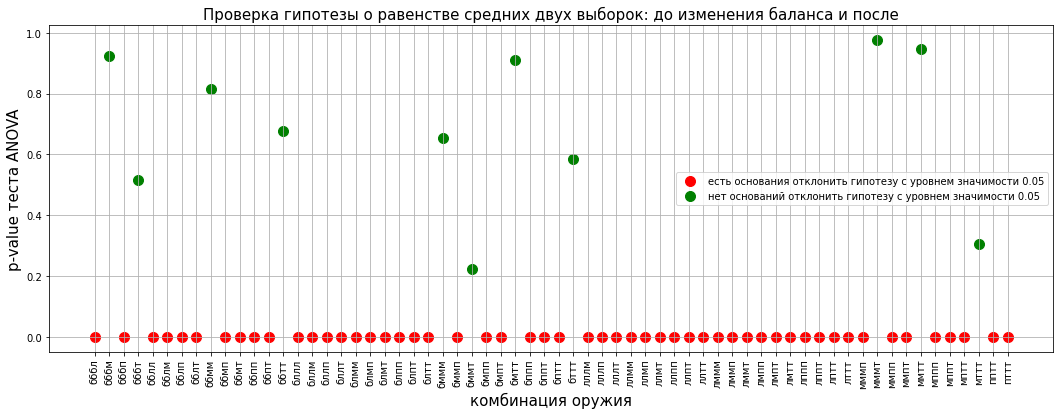

Комбинации оружия, для которых изменения не являются статистически значимыми:
бббм бббт ббмм ббтт бммм бммт бмтт бттт мммт ммтт мттт 
Среднее увеличилось в 87.143% случаях
Среднее уменьшилось в 7.143% случаях
Среднее незначительно изменилось (на 0.05 секунд) в 5.714% случаях
Результаты статистических тестов с поправкой на множественные сравнения (множественные проверки гипотез)
По алгоритму Бонферрони было отклонено 53 гипотез из 64
По алгоритму Хольма было отклонено 53 гипотез из 64


In [ ]:
ds.StatTestResults('f_oneway', alpha = 0.05)

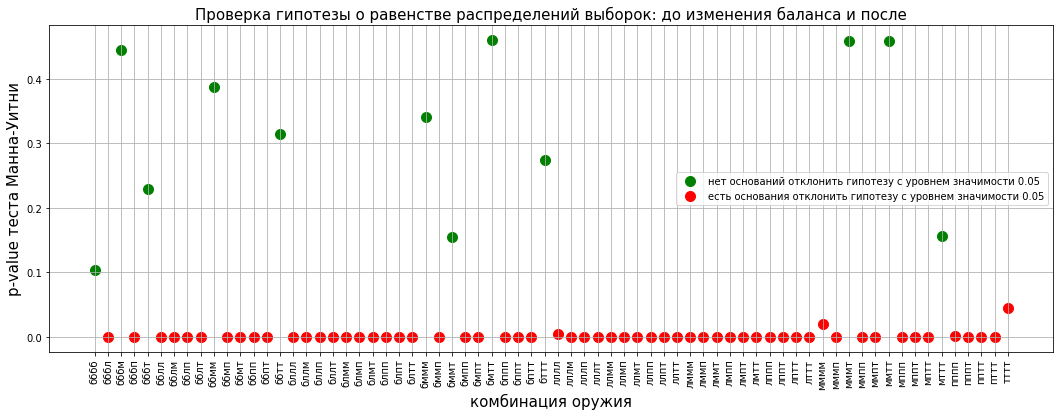

Комбинации оружия, для которых изменения не являются статистически значимыми:
бббб бббм бббт ббмм ббтт бммм бммт бмтт бттт мммт ммтт мттт 
Результаты статистических тестов с поправкой на множественные сравнения (множественные проверки гипотез)
По алгоритму Бонферрони было отклонено 54 гипотез из 70
По алгоритму Хольма было отклонено 55 гипотез из 70


In [ ]:
ds.StatTestResults('mannwhitneyu', alpha = 0.05)

### Визуализация распределений времени длительности боя в зависимости от комбинации оружий и наличия/отсутствия изменений насроек баланса

Построим ящики с усами, чтобы посмотреть, как изменились распределения длительности боя и средние значения в них в зависимости от комбинации оружий в игре. Комбинации закодированы, как уже упоминалось ранее, первыми буквами названий оружий, то есть комбинация **лмпт** означает, что в игре были использованы **лук**, **меч**, **посох** и **топор**, комбинация **бббб** означает, что были использованы **четыре булавы**.

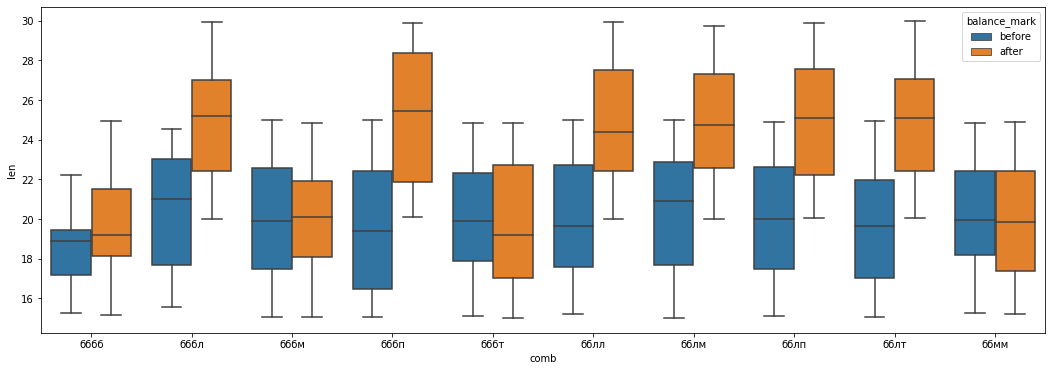

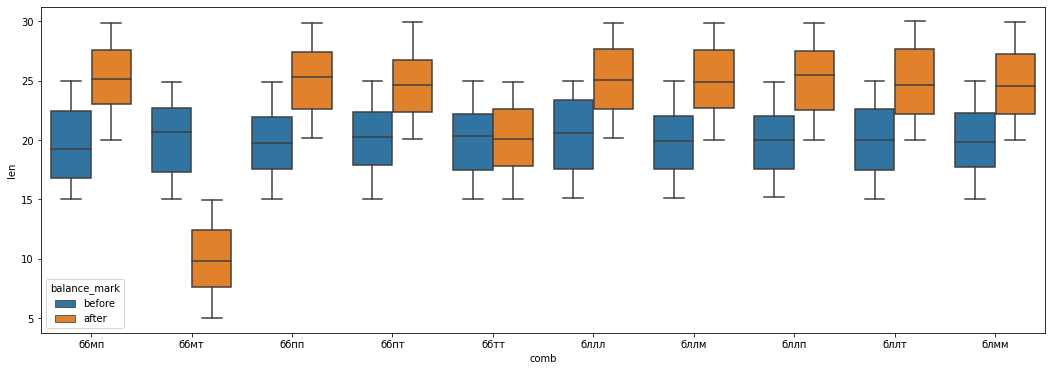

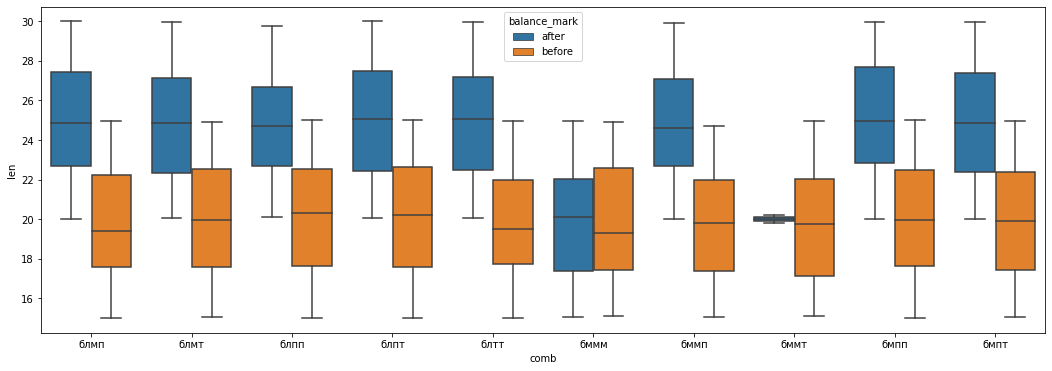

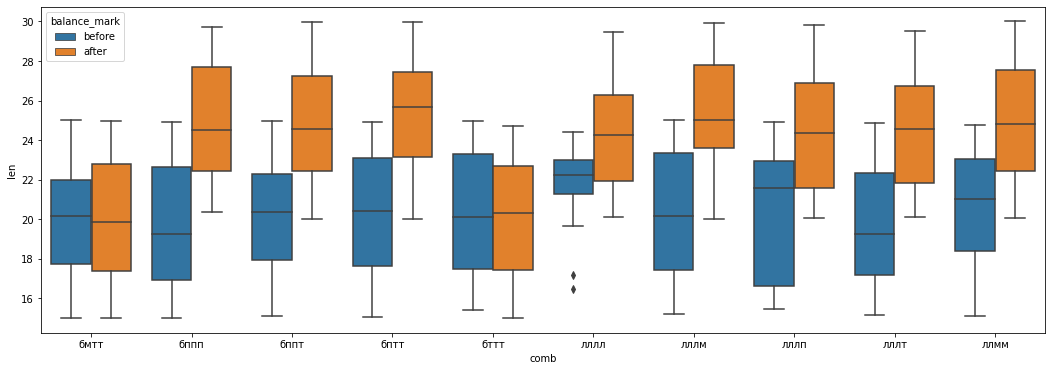

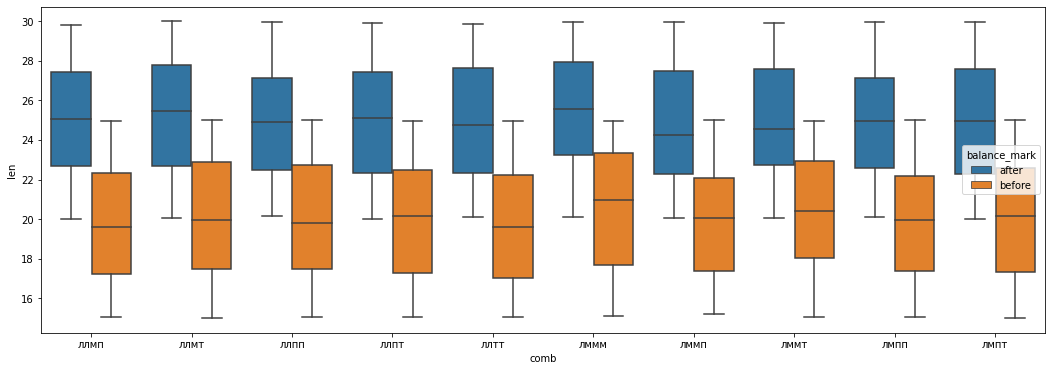

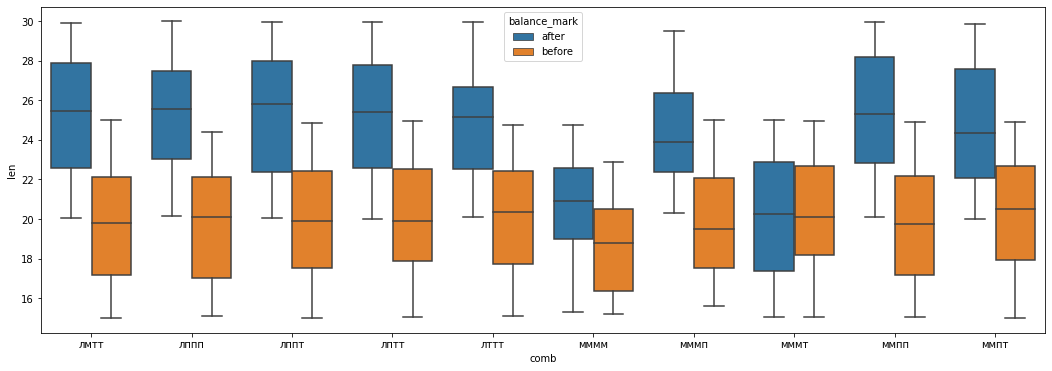

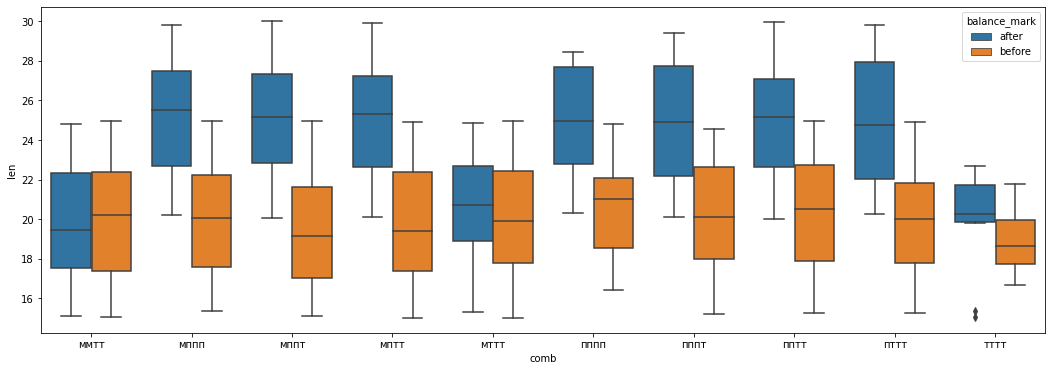

In [ ]:
ds.BoxPlotsResults()

Выведем также распределения длительности для всех комбинаций сразу.

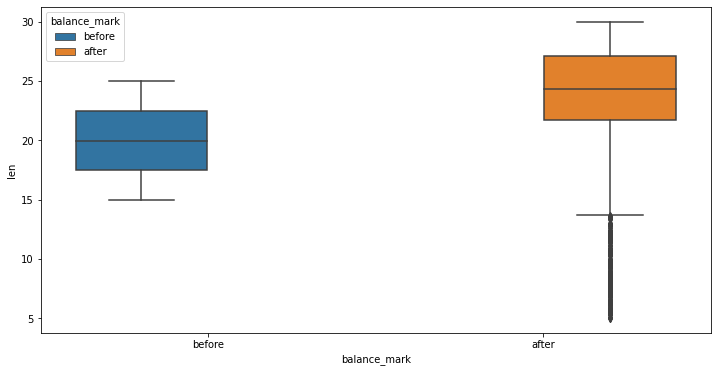

In [ ]:
ds.BoxPlotsResults(all_data = True)

Как видно из ящиков с усами распределения длительности боя действительно изменились в подавляющем большинстве случаев (комбинаций оружия) после измнений настроек баланса.

### Анализ главных компонент

Посмотрим, насколько хорошо можно классифицировать наши данные по меткам `before` и `after`. В качестве предикторов для классификации будем использовать длительность боя `len` и перекодированную с помощью `frequency encoding` комбинацию оружия.

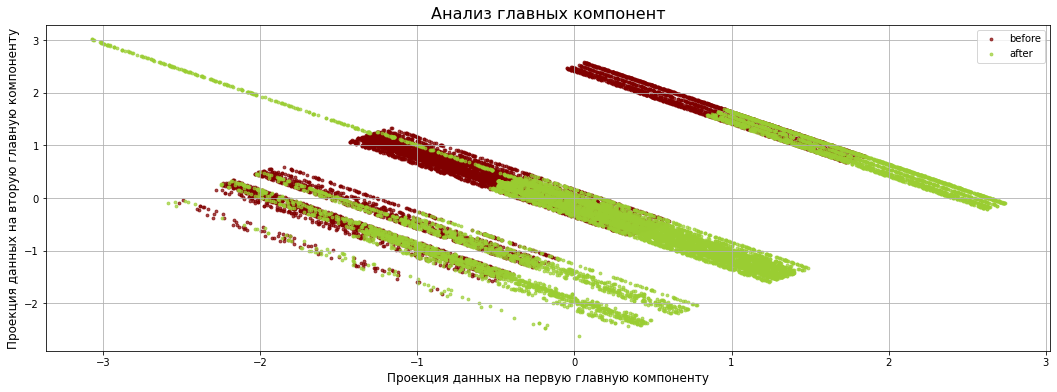

In [ ]:
ds.PCA()

Как видно, данные частично могут быть разделены, попробуем посмотреть, как справятся с этой задачей модели машинного обучения.

### Использования моделей машинного обучения

Разобьем нашу выборку на тестовую и обучающую, а затем построим несколько классификаторов на основе моделей машинного обучения и проверим, насколько хорошо они могут классифицировать данные, исходя из комбинации оружия (перекодированной с помощью `one-hot-encoding`) и длительности игры. В качестве моделей машинного обучения будут использованы: градиентный бустинг, логистическая регрессия и случайный лес.

In [ ]:
ds.MLDataSet()
X = ds.ML
y = labels_encode(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9)

F1_score для CatBoostClassifier: 0.733862959285005
F1_score для LogisticRegression: 0.719199567333694
F1_score для RandomForestClassifier: 0.7312853498946434


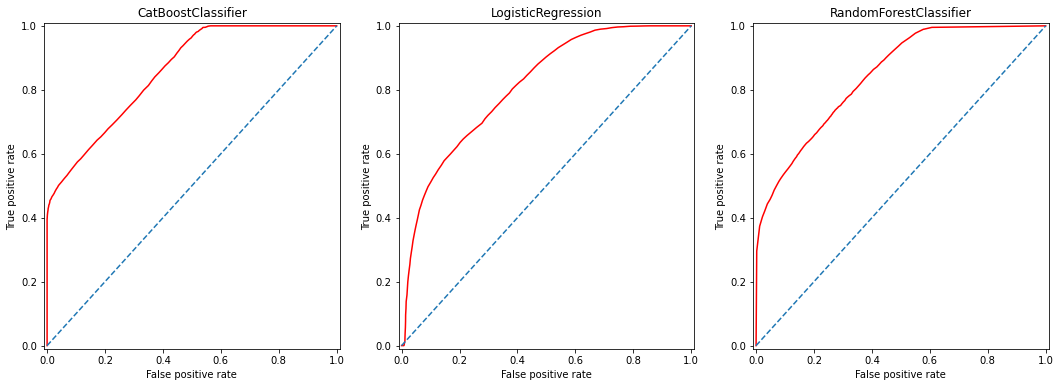

In [ ]:
plot_roc_curve(X_train, y_train, X_test, y_test)

## Выводы

- Судя по первичному анализу из `Pandas Profile Report` существует зависимость между признаками `len` и `balance_mark`, а также `len` слабо коррелирует с `unit_1` - `unit_4`.

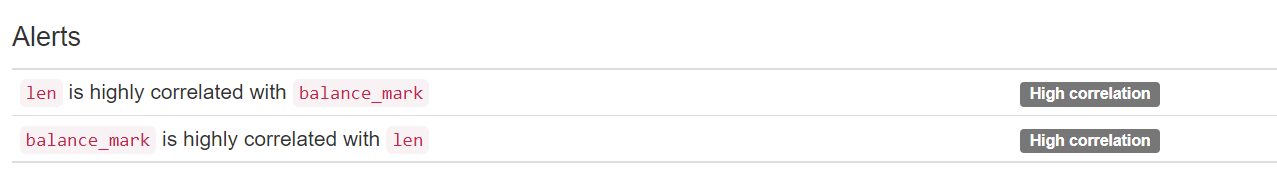

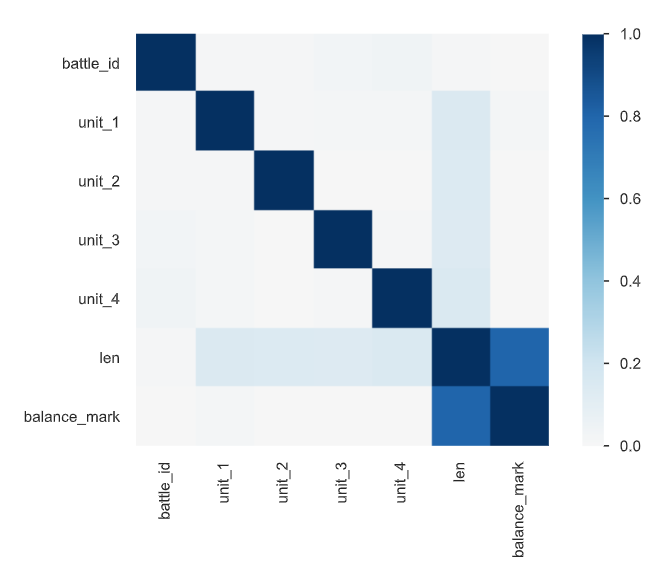

- Можно увидеть, что средние значения для всех комбинаций оружия до изменения настроек в балансе и после отличаются: до изменения настроек среднее равнялось $19.97$ секунд, после -- $24.12$ секунд. Можно предположить, что изменение настроек в балансе увеличивавет длительность боя, однако дальнейший анализ показал, что это не всегда так. Кроме того видно, что минимальное значение длительности боя до изменений настроек составляло $15.00$ секунд, а после -- $5.00$ секунд. Аналогично максимальное время было равно $25.00$ секунд, а стало равно $30.00$ секунд. То есть увеличился разброс длительности игры.

- После проведения ряда статистических тестов (T-теста и U-теста) без поправок на множественные сравнения выяснилось, что действительно изменились как средние значения длительности боя для большинства комбинаций, так и сами распределения времени боя для большинства комбинаций. 

- С учетом поправок на множественные сравнения (алгоримт Хольма и поправка Бонферрони) почти все гипотезы (как о равестве средних, так и о равенстве распределений) отклонились.

- Среднее значение длительности боя **увеличилось** в **87.143**% случаях, среднее **уменьшилось** в **7.143**% случаях, среднее **незначительно изменилось** (на 0.05 секунд) в **5.714**% случаях.

- Комбинации оружия, для которых p-value было больше принятого уровня значимости ($\alpha = 0.05$):
    - 4 булавы
    - 3 булавы, 1 меч
    - 3 булавы, 1 топор
    - 2 булавы, 2 меча
    - 2 булавы, 2 топора
    - 1 блуава, 3 меча
    - 1 булава, 2 меча, 1 топор
    - 1 булава, 1 меч, 2 топора
    - 1 булава, 3 топора
    - 3 меча, 1 топор
    - 2 меча, 2 топора
    - 1 меч, 3 топора
    - 4 топора
    
- Можно заметить, что в этих комбинациях не встречается оружие **лук**. Можно предположить, что изменение настроек баланса для лука сильно повлияло на длительность боя.

- Далее для каждой комбинации оружия из датасета были построены ящики с усами. По ним уже отчетливо видно, что распределения длительности боя после изменения настроек баланса действительно сильно изменились. 

- С помощью анализа главных компонент было показано, что можно разделить данные по меткам `before` и `after`. Было решено посмотреть, как справятся с этим модели машинного обучения.

- Также были построены классификаторы, `f1_score` которых показывает достаточно высокое значение. И площадь под roc-кривой для всех трех классификаторов достаточно большая, то есть данные можно хорошо классифицировать, учитывая длительность боя и комбинации оружия (которые были перекодированы с помощью `one-hot-encoding`). Исходя из этого также можно сказать, что после изменений настроек в балансе произошли изменения в длительности боя.

### Резюме

С учетом всех положений приведенных выше можно сделать вывод, что **изменения** в настройках баланса оружия действительно в общем **повлияли** на **время длительности** боя. Но в ряде случаев эти изменения были либо незначительное, либо приводили к уменьшению длительности боя. Однако в **87**% процентах случаев в среднем **время** боя **увеличивалось**.